<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S7_3_2_Introduction_aux_GAN_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Créer des handwritten digits avec des GAN 


Les [GAN ou Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) sont une des dernières avancées du Deep Learning, le principe est assez simple. Au lieu d'avoir un modèle qui va générer des images, nous allons avoir deux modèle : 

* **Un générateur** : Le premier va essayer de créer des images à partir du dataset d'images qu'on lui donne 
* **Un discriminateur** : Un autre modèle va essayer de distinguer les images créées par le générateur des vraies images

Tout est ensuite une bataille entre le générateur qui va tenter de créer des images tellement parfaite que le discriminateur n'arrive plus à distinguer les _vraies_ images des images _générées_

Tentons d'implémenter cela sur MNIST : 

[![Texte alternatif…](https://tensorflow.org/images/gan/dcgan.gif)]

* Importez les librairies suivantes 
  * tensorflow 2.0 
  * glob
  * matplotlib.pyplot
  * numpy
  * os 
  * time 
  * display from IPython

In [0]:
!pip install tensorflow-gpu==2.0.0beta1
import tensorflow as tf 
import glob 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import time 
from IPython import display

     |████████████████████████████████| 348.9MB 67kB/s 
     |████████████████████████████████| 3.1MB 23.8MB/s 
     |████████████████████████████████| 501kB 34.2MB/s 


* Nous avons besoin de télécharger le dataset MNIST. Vous pouvez le faire via [`tf.keras.datasets.mnist`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [0]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
print(X_train[:2], y_train[:2])

11493376/11490434 [==============================] - 0s 0us/step
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [5 0]


* Il va falloir qu'on passe par une phase de preprocessing des données. 
  * Commencer par effectuer un `reshape` sur vos images d'entrainement pour qu'elles aient la shape suivante : (sample, height, width, channels = 1). 
  * Convertissez ces images en `float32`
  * Normalisez vos images pour que chacun des pixels se retrouvent dans l'intervalle [-1, 1]. Vous pourrez tout simplement soustraire chacun des pixels par 127.5 (255/2) puis diviser le tout par 127.5 (255/2)

In [0]:
train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 255/2)/255/2
train_images[:2]

array([[[[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]],

        [[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]],

        [[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]],

        ...,

        [[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]],

        [[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]],

        [[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]]],


       [[[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0.25]],

        [[-0.25],
         [-0.25],
         [-0.25],
         ...,
         [-0.25],
         [-0.25],
         [-0

* Visualisez une image dans votre dataset via matplotlib 

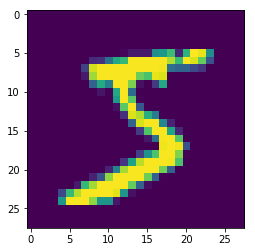

In [0]:
plt.imshow(train_images[0].squeeze())

* Créez un [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) à partir de vos images de train. Vous appliquerez ensuite les dernières phases de preprocessing :
  * Appliquez un shuffle avec un Buffer_Size de 6000
  * Convertissez les images en batch de 256 images 

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_set = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
for i in train_set.take(1):
  print(i)

tf.Tensor(
[[[[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  ...

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]]


 [[[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  ...

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]

  [[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25]]]


 [[[-0.25]
   [-0.25]
   [-0.25]
   ...
   [-0.25]
   [-0.25]
   [-0.25

* Nous allons maintenant créer notre _générateur_. Ce modèle prendra comme input des pixels complètement aléatoires qu'on appellera du _bruit_. L'input passera par une série de couches [_Conv2DTranspose_](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) qui vont produire une image à partir de ce random seed. Ces _Conv2DTranspose_ marche à l'inverse d'une convolution, qu'on appelle, de fait une _déconvolution_. Créez donc un modèle avec la structure suivante : 

    * Dense(7*7*256, use_bias=False, input_shape=(100,))
    * BatchNormalization()
    * LeakyReLU()

    * Reshape((7, 7, 256))

    * Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    * BatchNormalization()
    * LeakyReLU()

    * Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    * BatchNormalization()
    * LeakyReLU()

    * Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

NB : La fonction d'activation [LeakyRelu()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LeakyReLU) qui est adapté pour ce genre de problématique. LeakyRelu, à l'inverse de Relu, ne mets pas le neurone à 0 s'il n'est pas actif mais laisse un gradient.

`f(x) = alpha * x for x < 0`

`f(x) = x for x >= 0`

In [0]:
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Reshape((7,7, 256)),
        
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh")
        
    ])

    return model


* Testez votre modèle en créant une image complètement aléatoire. Pour cela : 
  * Créez un tenseurs de pixels aléatoires d'une shape de (100,) ---> Tentez de regarder [`tf.random.normal`](https://www.tensorflow.org/api_docs/python/tf/random/normal)
  * Appliquez votre modèle sur ce tenseur aléatoire 
  * Visualisez avec plt

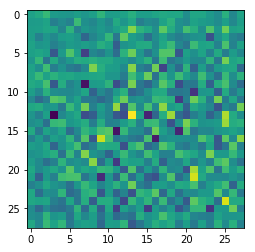

In [0]:
### instanciation du modèle
generator = make_generator_model()

### Création de pixels aléatoire de taille (1, 100)
random_pixels = tf.random.normal([1,100])

### Application du modèle
rand_img = generator(random_pixels, training=False)

### Visualisation du modèle 
plt.imshow(rand_img.numpy().squeeze())

* Créons maintenant notre _discrimateur_. Ce modèle sera un simple CNN binaire qui va tenter de prédire si l'image est un faux ou un vrai. Vous pouvez prendre la structure suivante : 

  * Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  * LeakyReLU()
  * Dropout(0.3)
  
  * Conv2D(128, (5, 5), strides=(2, 2), padding='same')
  * LeakyReLU()
  * Dropout(0.3)
  
  * Flatten()
  * Dense(1)

In [0]:
def make_discriminator_model():
  
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)        
    ])

    return model 

* Testez votre modèle sur une image aléatoire. Celui-ci ne nous donnera pas des prédictions justes, le but est de vérifier que votre modèle fonctionne. 

In [0]:
discriminator = make_discriminator_model()
discriminator(rand_img)

<tf.Tensor: id=3036, shape=(1, 1), dtype=float32, numpy=array([[-0.00086636]], dtype=float32)>

* Nous allons maintenant définir deux fonctions de coût : `discriminator_loss` et `generator_loss`
  * **discriminator_loss** : devra définir à quel point notre discriminateur distingue les fausses images des vraies 
  * **generator_loss** : devra définir à quel notre generator arrive à _tromper_ notre discriminateur
  
  Créez une variable `cross_entropy` qui stockera la fonction `tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

* Définissez votre `discriminator_loss`. Cette fonction prendra une somme de deux `loss`:
  * `real_loss`: qui sera égale à la cross_entropy entre y_true_real & y_pred
  * `fake_loss`: qui sera égale à la cross_entropy entre y_true_fake & y_pred
  
  `y_true_real` étant les valeurs qu'auraient dû trouver le modèle sur des images réelles : Ceci s'apparente en fait simple à une matrice de 1
  
  `y_true_fake` étant les valeurs qu'auraient dû trouver le modèle sur images factices : Ceci s'apparente simplement à une matrice de 0

In [0]:
def discriminator_loss(real_outputs, fake_outputs):
  real_loss = cross_entropy(tf.ones_like(real_outputs), real_outputs)
  fake_loss = cross_entropy(tf.zeros_like(fake_outputs), fake_outputs)
  
  total_loss = real_loss + fake_loss 
  return total_loss

* Définissez maintenant `generator_loss` qui devra définir à quel point notre modèle arrive à tromper notre `discriminator`. Autremement dit, si notre `discriminator` définit une fausse image comme une _vraie image_ cela devra faire baisser `generator_loss`. 

Il suffira donc de calculer la cross entropy entre des images factices classées comme des images réelles et les prédictions de notre `generator` sur des images factices 

In [0]:
def generator_loss(fake_outputs):
  return cross_entropy(tf.ones_like(fake_outputs), fake_outputs)

* Définissons maintenant deux optimiseurs pour nos deux fonctions de coût. Créez deux optimiseurs Adam avec un learning rate à `1e-4` chacun 

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

* Nous allons pouvoir créer notre boucle d'entrainement ! Commencons d'abord par définir quelques variables : 
  * EPOCHS = 50 ---> Nous allons définir 50 epochs pour notre boucle 
  * noise_dim = 100 ---> La dimension de notre tenseur aléatoire 
  * num_examples_to_generate = 16 ---> Nous créerons 16 images aléatoires 
  * seed = tf.random.normal([num_examples_to_generate, noise_dim]) ----> Nos images aléatoires 

In [0]:
EPOCHS = 70
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

* Nous allons maintenant définir une fonction `train_step` qui va définir comment une étape de l'entrainement du modèle va se passer. Pour cela, vous devrez implémenter les choses suivantes :
  * Initialisez une variable _noise_ qui sera égale à un tenseurs aléatoire de taille ([Batch_size, noise_dim])
  * Commencez à enregistrer les gradients dans un block : `with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
    NB : En effet, nous suivrons les gradients des deux fonctions de coûts *gen_loss* et *disc_loss* . Une fois ceci fait, vous devrez à l'intérieur du block :
    * Appliquer votre modèle _generator_ sur votre variable _noise_
    * Appliquer votre _discriminator_ sur votre batch d'images réelles et sur vos images générées 
    * Calculez la *gen_loss* de votre _generator_ sur votre fausse image
    * Calculez la *disc_loss* de votre _discriminator_ entre vos images réelles et vos images générées
  * Une fois que vous avez codé votre block, vous devrez appliquer vos gradients sur *gen_loss* & *disc_loss* 
    * Vous pouvez le faire via `gen_tape.gradient(loss, weights)` & `disc_tape.gradient(loss, weights)`. N'hésitez pas à regarder cette documentation pour vous aider : [`GradientTape`](https://www.tensorflow.org/tutorials/eager/automatic_differentiation) & [`trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables)
  * Enfin, appliquez vos gradient grâce aux optimiseurs que vous avez définis plus haut. N'hésitez pas à vous aider de cette documentation [`apply_gradients`](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#apply_gradients)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

* Avant d'appliquer notre fonction d'entrainement, nous allons devoir créer une dernière fonction qui va permettre de générer et sauvegarder une image. Cela nous permettra de regarder la tête d'un batch d'images et s'apercevoir de comment notre modèle s'entraine. Appliquez le code suivant pour pouvoir regarder et enregistrer une image :

```
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
 ```

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

* Allons-y ! Commençons notre entrainement. Pour cela, vous aurez besoin de :

  * Créer une première boucle qui va itérer sur le nombre d'épochs que vous avez définies
  * Vous pouvez utiliser `time.time()` pour enregistrer le temps que prend chaque itération
  * A l'intérieur de cette boucle créer une nouvelle boucle qui itérera sur chacun des batchs de votre *train_set*
    * A l'intérieur de cette dernière boucle, appliquez votre fonction *train_step* sur votre batch d'images
    * Ajoutez une ligne `display.clear_output(wait=True)` cela permet d'éviter d'avoir trop d'outputs dans notre console 
    * Appliquez la fonction *generate_and_save_images* avec comme argument votre _generator_, votre nombre d'epochs + 1, votre *test_input*
  * Une fois que vous avez terminé votre boucle d'epochs, appliquez une dernière fois votre fonction *generate_and_save_images* pour afficher vos images créées par votre modèle. 

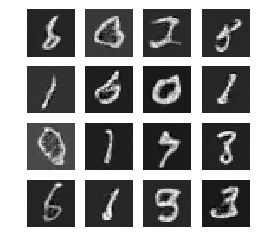

In [0]:
for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_set:
    train_step(image_batch)

  # Enlève l'image précédente et enregistre la nouvelle
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epoch + 1,
                           seed)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Génère la toute dernière image
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)

Bravo ! Vous avez réussit à créer des images en utilisant un principe simple de GAN. C'est une belle avancée en Deep Learning. Vous pouvez tenter d'appliquer ca sur d'autres types d'images maintenant. 